In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [5]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [7]:
nfs = [8,16,32,64,64]

In [8]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

Metrics:
<function accuracy at 0x7feebb395e18>
Metrics:
<function accuracy at 0x7feebb395e18>


In [9]:
%time run.fit(2, learn)

train: [1.6451540625, tensor(0.4413, device='cuda:0')]
valid: [0.405144921875, tensor(0.8681, device='cuda:0')]
train: [0.269253515625, tensor(0.9165, device='cuda:0')]
valid: [0.1485333984375, tensor(0.9509, device='cuda:0')]
CPU times: user 12 s, sys: 3.02 s, total: 15 s
Wall time: 27 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [10]:
class BatchNorm(nn.Module): # nf number of filters
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
            print(m)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [11]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [12]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [13]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

Metrics:
<function accuracy at 0x7feebb395e18>
Metrics:
<function accuracy at 0x7feebb395e18>


In [56]:
learn.model[0][2].mults, learn.model[0][2].adds, learn.model[0][0].weight, learn.model

(Parameter containing:
 tensor([[[1.4311]],
 
         [[1.6707]],
 
         [[1.4983]],
 
         [[0.7902]],
 
         [[1.1550]],
 
         [[0.9599]],
 
         [[1.3351]],
 
         [[1.0985]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[ 0.1510]],
 
         [[-0.1416]],
 
         [[-0.0154]],
 
         [[ 0.2880]],
 
         [[ 0.0074]],
 
         [[-0.2211]],
 
         [[-0.0891]],
 
         [[-0.0758]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[[ 3.2673e-01, -4.0895e-01, -4.6189e-01, -2.3045e-01, -1.4938e-01],
           [ 1.2137e-01, -2.0384e-01, -9.2740e-01, -4.6862e-01, -2.8914e-01],
           [-7.7978e-01, -1.4199e+00, -6.2296e-01, -1.7435e-01,  2.2356e-01],
           [-8.2712e-01, -6.1046e-01, -4.0323e-02,  2.8165e-01,  1.0199e+00],
           [-7.7368e-01, -4.8329e-01,  4.2812e-01,  7.2656e-01,  7.5583e-01]]],
 
 
         [[[-5.2581e-01,  2.5834e-02,  5.2102e-03,  3.2452e-01,  5.2763e-02],
       

In [14]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

tensor([[[[0.5380]],

         [[0.7037]],

         [[0.2465]],

         [[0.6206]],

         [[0.5459]],

         [[0.7180]],

         [[0.3597]],

         [[0.2866]]]], device='cuda:0')
tensor([[[[0.6885]],

         [[0.4561]],

         [[0.5030]],

         [[0.3242]],

         [[0.4361]],

         [[0.4356]],

         [[0.4046]],

         [[0.3711]],

         [[0.5047]],

         [[0.5058]],

         [[0.4724]],

         [[0.4254]],

         [[1.0097]],

         [[0.4900]],

         [[0.7439]],

         [[0.8692]]]], device='cuda:0')
tensor([[[[0.5067]],

         [[0.2668]],

         [[0.4705]],

         [[0.3406]],

         [[0.4603]],

         [[0.4717]],

         [[0.3184]],

         [[0.4291]],

         [[0.3129]],

         [[0.3718]],

         [[0.4452]],

         [[0.5655]],

         [[0.3237]],

         [[0.5116]],

         [[0.5332]],

         [[0.6298]],

         [[0.3657]],

         [[0.4771]],

         [[0.4126]],

         [[0.3838]

tensor([[[[0.6068]],

         [[0.3800]],

         [[0.7568]],

         [[0.5509]],

         [[0.6682]],

         [[0.4559]],

         [[0.4766]],

         [[0.4024]],

         [[0.4215]],

         [[0.8519]],

         [[0.5468]],

         [[0.7656]],

         [[0.5450]],

         [[0.5745]],

         [[0.6058]],

         [[0.6332]],

         [[0.3914]],

         [[0.4785]],

         [[0.5136]],

         [[0.3689]],

         [[0.7075]],

         [[0.9477]],

         [[1.3217]],

         [[0.4901]],

         [[1.3783]],

         [[0.3922]],

         [[0.3979]],

         [[0.6784]],

         [[0.6675]],

         [[0.9981]],

         [[0.5454]],

         [[0.8854]]]], device='cuda:0')
tensor([[[[0.5826]],

         [[0.6016]],

         [[0.3115]],

         [[0.2894]],

         [[0.6855]],

         [[0.6966]],

         [[0.7550]],

         [[0.6740]],

         [[0.9470]],

         [[0.8396]],

         [[0.8183]],

         [[0.6480]],

         [[0.7

tensor([[[[0.7890]],

         [[1.9434]],

         [[1.2741]],

         [[0.9079]],

         [[1.1900]],

         [[0.8171]],

         [[1.3093]],

         [[1.6970]],

         [[0.6401]],

         [[1.1642]],

         [[2.5341]],

         [[2.4510]],

         [[2.1511]],

         [[1.6405]],

         [[2.0171]],

         [[1.8948]]]], device='cuda:0')
tensor([[[[0.7132]],

         [[0.5176]],

         [[0.8496]],

         [[0.5495]],

         [[0.7357]],

         [[0.4612]],

         [[0.6744]],

         [[0.4093]],

         [[0.4107]],

         [[0.7356]],

         [[0.4879]],

         [[0.8355]],

         [[0.4810]],

         [[0.6004]],

         [[0.7106]],

         [[0.7168]],

         [[0.4818]],

         [[0.5321]],

         [[0.4150]],

         [[0.3630]],

         [[0.7823]],

         [[0.9552]],

         [[1.2978]],

         [[0.5944]],

         [[1.2471]],

         [[0.4107]],

         [[0.5347]],

         [[0.6965]],

         [[0.6

tensor([[[[0.5853]],

         [[1.1383]],

         [[0.7408]],

         [[0.5536]],

         [[1.3698]],

         [[0.5878]],

         [[1.4871]],

         [[0.9096]]]], device='cuda:0')
tensor([[[[0.7599]],

         [[2.1326]],

         [[1.4097]],

         [[1.0208]],

         [[1.4032]],

         [[0.9796]],

         [[1.6093]],

         [[1.9607]],

         [[0.7114]],

         [[1.4644]],

         [[2.7475]],

         [[2.7813]],

         [[2.4614]],

         [[1.7762]],

         [[2.3454]],

         [[2.0219]]]], device='cuda:0')
tensor([[[[0.7482]],

         [[0.4514]],

         [[0.9748]],

         [[0.3905]],

         [[0.7973]],

         [[0.5223]],

         [[0.5909]],

         [[0.4483]],

         [[0.4314]],

         [[0.8391]],

         [[0.5974]],

         [[0.9099]],

         [[0.6980]],

         [[0.7097]],

         [[0.7414]],

         [[0.8015]],

         [[0.4637]],

         [[0.5504]],

         [[0.3911]],

         [[0.3636]

tensor([[[[0.6372]],

         [[1.1778]],

         [[0.7357]],

         [[0.6060]],

         [[1.5185]],

         [[0.6156]],

         [[1.6125]],

         [[0.9922]]]], device='cuda:0')
tensor([[[[0.8202]],

         [[2.3236]],

         [[1.7028]],

         [[1.2808]],

         [[1.5930]],

         [[1.1031]],

         [[1.9254]],

         [[2.3479]],

         [[0.8049]],

         [[1.7380]],

         [[3.1065]],

         [[3.1886]],

         [[2.8268]],

         [[2.0241]],

         [[2.6237]],

         [[2.0556]]]], device='cuda:0')
tensor([[[[0.7760]],

         [[0.4855]],

         [[1.0365]],

         [[0.3978]],

         [[0.8545]],

         [[0.6307]],

         [[0.6506]],

         [[0.4998]],

         [[0.3444]],

         [[0.9700]],

         [[0.6508]],

         [[0.9571]],

         [[0.8473]],

         [[0.7497]],

         [[0.7759]],

         [[0.8547]],

         [[0.5794]],

         [[0.5754]],

         [[0.4093]],

         [[0.4184]

tensor([[[[0.6439]],

         [[1.2230]],

         [[0.7087]],

         [[0.5916]],

         [[1.5942]],

         [[0.6524]],

         [[1.6883]],

         [[1.0386]]]], device='cuda:0')
tensor([[[[0.8460]],

         [[2.4914]],

         [[1.9951]],

         [[1.6052]],

         [[1.8428]],

         [[1.1875]],

         [[2.1518]],

         [[2.6940]],

         [[0.8509]],

         [[1.9075]],

         [[3.2796]],

         [[3.5035]],

         [[3.0387]],

         [[2.1510]],

         [[2.8184]],

         [[2.1520]]]], device='cuda:0')
tensor([[[[0.8186]],

         [[0.5565]],

         [[1.1620]],

         [[0.3577]],

         [[0.8632]],

         [[0.7446]],

         [[0.7418]],

         [[0.4814]],

         [[0.3490]],

         [[0.9837]],

         [[0.7122]],

         [[0.9499]],

         [[0.9470]],

         [[0.7889]],

         [[0.8344]],

         [[0.9092]],

         [[0.7412]],

         [[0.6106]],

         [[0.4504]],

         [[0.4541]

tensor([[[[0.6780]],

         [[1.2716]],

         [[0.7204]],

         [[0.6264]],

         [[1.5937]],

         [[0.6450]],

         [[1.6815]],

         [[1.0582]]]], device='cuda:0')
tensor([[[[0.8388]],

         [[2.6576]],

         [[2.1749]],

         [[1.6908]],

         [[1.8971]],

         [[1.3748]],

         [[2.2134]],

         [[2.8954]],

         [[0.9525]],

         [[2.1562]],

         [[3.4646]],

         [[3.7081]],

         [[3.1970]],

         [[2.1397]],

         [[3.0841]],

         [[2.3791]]]], device='cuda:0')
tensor([[[[0.8365]],

         [[0.6257]],

         [[1.1549]],

         [[0.3331]],

         [[0.9225]],

         [[0.7514]],

         [[0.7328]],

         [[0.4977]],

         [[0.3571]],

         [[1.0321]],

         [[0.7919]],

         [[0.9531]],

         [[1.0271]],

         [[0.8038]],

         [[0.8508]],

         [[0.9988]],

         [[0.6273]],

         [[0.7027]],

         [[0.4451]],

         [[0.4694]

tensor([[[[0.6519]],

         [[1.2067]],

         [[0.7530]],

         [[0.6118]],

         [[1.5988]],

         [[0.6507]],

         [[1.6888]],

         [[1.0658]]]], device='cuda:0')
tensor([[[[0.8010]],

         [[2.5442]],

         [[2.1065]],

         [[1.6256]],

         [[1.7017]],

         [[1.3175]],

         [[2.2292]],

         [[2.5871]],

         [[0.8608]],

         [[2.1453]],

         [[3.3875]],

         [[3.3498]],

         [[2.9399]],

         [[2.0408]],

         [[2.8515]],

         [[2.1680]]]], device='cuda:0')
tensor([[[[0.8253]],

         [[0.5587]],

         [[1.1230]],

         [[0.3304]],

         [[0.9039]],

         [[0.9093]],

         [[0.7742]],

         [[0.4705]],

         [[0.3560]],

         [[1.0292]],

         [[0.7703]],

         [[0.9558]],

         [[0.8709]],

         [[0.7930]],

         [[0.8336]],

         [[0.9686]],

         [[0.7009]],

         [[0.6488]],

         [[0.5159]],

         [[0.5269]

tensor([[[[0.6941]],

         [[1.2692]],

         [[0.7462]],

         [[0.6393]],

         [[1.6234]],

         [[0.7034]],

         [[1.7135]],

         [[1.0710]]]], device='cuda:0')
tensor([[[[0.8759]],

         [[2.5694]],

         [[2.1762]],

         [[1.7975]],

         [[1.8950]],

         [[1.3023]],

         [[2.3292]],

         [[2.6968]],

         [[0.9487]],

         [[2.2893]],

         [[3.4903]],

         [[3.5075]],

         [[3.1019]],

         [[2.0340]],

         [[2.9743]],

         [[2.1289]]]], device='cuda:0')
tensor([[[[0.8562]],

         [[0.5920]],

         [[1.1427]],

         [[0.3410]],

         [[0.9374]],

         [[0.9232]],

         [[0.8022]],

         [[0.5071]],

         [[0.3475]],

         [[0.9906]],

         [[0.8215]],

         [[0.9703]],

         [[0.9609]],

         [[0.7762]],

         [[0.8311]],

         [[1.0012]],

         [[0.7093]],

         [[0.6799]],

         [[0.5566]],

         [[0.5383]

tensor([[[[0.7339]],

         [[1.2986]],

         [[0.7604]],

         [[0.6347]],

         [[1.6876]],

         [[0.7078]],

         [[1.7913]],

         [[1.1127]]]], device='cuda:0')
tensor([[[[0.9743]],

         [[2.7039]],

         [[2.3338]],

         [[1.8939]],

         [[2.0972]],

         [[1.3545]],

         [[2.5269]],

         [[2.9753]],

         [[0.9772]],

         [[2.4427]],

         [[3.6378]],

         [[3.8039]],

         [[3.3284]],

         [[2.0800]],

         [[3.2241]],

         [[2.2662]]]], device='cuda:0')
tensor([[[[0.8318]],

         [[0.5686]],

         [[1.1368]],

         [[0.3624]],

         [[0.9553]],

         [[0.9964]],

         [[0.7925]],

         [[0.5023]],

         [[0.3509]],

         [[1.0864]],

         [[0.8886]],

         [[0.9782]],

         [[1.1813]],

         [[0.8263]],

         [[0.8803]],

         [[1.0487]],

         [[0.5538]],

         [[0.7453]],

         [[0.5071]],

         [[0.5341]

tensor([[[[3.9554]],

         [[1.8004]],

         [[2.9709]],

         [[5.1210]],

         [[1.5316]],

         [[5.2723]],

         [[0.7904]],

         [[2.3134]],

         [[1.6086]],

         [[1.4941]],

         [[2.2151]],

         [[3.4850]],

         [[1.5047]],

         [[0.6704]],

         [[1.5986]],

         [[1.4746]],

         [[0.8615]],

         [[0.7260]],

         [[1.4233]],

         [[1.1027]],

         [[3.1757]],

         [[0.7136]],

         [[0.9779]],

         [[0.7524]],

         [[3.2333]],

         [[5.4718]],

         [[1.5780]],

         [[3.0615]],

         [[0.6098]],

         [[0.2705]],

         [[2.4675]],

         [[0.7525]],

         [[3.7384]],

         [[0.8014]],

         [[0.9839]],

         [[1.8687]],

         [[2.9924]],

         [[2.8231]],

         [[0.2954]],

         [[2.5228]],

         [[0.8242]],

         [[1.3388]],

         [[2.2443]],

         [[2.3774]],

         [[0.9720]],

         [

tensor([[[[0.7599]],

         [[1.3438]],

         [[0.7672]],

         [[0.6375]],

         [[1.7784]],

         [[0.7349]],

         [[1.8408]],

         [[1.1677]]]], device='cuda:0')
tensor([[[[1.0660]],

         [[2.8430]],

         [[2.4283]],

         [[2.0544]],

         [[2.2292]],

         [[1.4879]],

         [[2.7010]],

         [[3.0782]],

         [[1.0528]],

         [[2.5645]],

         [[3.7282]],

         [[3.8425]],

         [[3.4276]],

         [[2.1155]],

         [[3.3581]],

         [[2.2923]]]], device='cuda:0')
tensor([[[[0.8714]],

         [[0.6767]],

         [[1.2151]],

         [[0.3554]],

         [[0.9351]],

         [[1.0993]],

         [[0.8659]],

         [[0.4941]],

         [[0.3441]],

         [[1.0796]],

         [[0.9125]],

         [[1.0333]],

         [[1.0954]],

         [[0.8541]],

         [[0.8742]],

         [[1.0437]],

         [[0.6526]],

         [[0.7289]],

         [[0.5662]],

         [[0.5553]

tensor([[[[0.8004]],

         [[1.4163]],

         [[0.7703]],

         [[0.6475]],

         [[1.7655]],

         [[0.7907]],

         [[1.8227]],

         [[1.1757]]]], device='cuda:0')
tensor([[[[1.1641]],

         [[2.9001]],

         [[2.4922]],

         [[2.0057]],

         [[2.1412]],

         [[1.5291]],

         [[2.6104]],

         [[2.9410]],

         [[1.0862]],

         [[2.5200]],

         [[3.6469]],

         [[3.7165]],

         [[3.3490]],

         [[1.9726]],

         [[3.3185]],

         [[2.3276]]]], device='cuda:0')
tensor([[[[0.8565]],

         [[0.6340]],

         [[1.2439]],

         [[0.4100]],

         [[0.9394]],

         [[1.0644]],

         [[0.7754]],

         [[0.5120]],

         [[0.3608]],

         [[1.1642]],

         [[0.8872]],

         [[1.0442]],

         [[1.0230]],

         [[0.8764]],

         [[0.8936]],

         [[0.9855]],

         [[0.6353]],

         [[0.7350]],

         [[0.5521]],

         [[0.5434]

tensor([[[[0.7856]],

         [[1.4635]],

         [[0.7470]],

         [[0.6499]],

         [[1.7467]],

         [[0.8304]],

         [[1.7852]],

         [[1.1655]]]], device='cuda:0')
tensor([[[[1.1691]],

         [[2.8502]],

         [[2.4783]],

         [[2.0539]],

         [[2.0390]],

         [[1.6277]],

         [[2.6253]],

         [[2.8824]],

         [[1.1327]],

         [[2.5962]],

         [[3.6923]],

         [[3.6643]],

         [[3.3516]],

         [[2.0327]],

         [[3.2588]],

         [[2.2069]]]], device='cuda:0')
tensor([[[[0.8857]],

         [[0.6986]],

         [[1.2600]],

         [[0.4369]],

         [[0.9498]],

         [[1.1143]],

         [[0.8287]],

         [[0.5365]],

         [[0.3955]],

         [[1.1587]],

         [[0.9446]],

         [[1.0446]],

         [[0.9168]],

         [[0.8702]],

         [[0.8879]],

         [[0.9899]],

         [[0.7501]],

         [[0.7611]],

         [[0.7053]],

         [[0.5777]

tensor([[[[0.8038]],

         [[1.4875]],

         [[0.7780]],

         [[0.6359]],

         [[1.7978]],

         [[0.8316]],

         [[1.8417]],

         [[1.1863]]]], device='cuda:0')
tensor([[[[1.2318]],

         [[2.9029]],

         [[2.5419]],

         [[2.1128]],

         [[2.1147]],

         [[1.4982]],

         [[2.6970]],

         [[3.0019]],

         [[1.1355]],

         [[2.5943]],

         [[3.7327]],

         [[3.8370]],

         [[3.4365]],

         [[2.1165]],

         [[3.3928]],

         [[2.3245]]]], device='cuda:0')
tensor([[[[0.8692]],

         [[0.6588]],

         [[1.2563]],

         [[0.4463]],

         [[0.9492]],

         [[1.1249]],

         [[0.7324]],

         [[0.5623]],

         [[0.3908]],

         [[1.1430]],

         [[0.9538]],

         [[1.0866]],

         [[0.9892]],

         [[0.9185]],

         [[0.9310]],

         [[1.0107]],

         [[0.6672]],

         [[0.7596]],

         [[0.6438]],

         [[0.5435]

tensor([[[[0.8347]],

         [[1.5179]],

         [[0.7711]],

         [[0.6010]],

         [[1.7541]],

         [[0.8053]],

         [[1.8149]],

         [[1.1745]]]], device='cuda:0')
tensor([[[[1.2475]],

         [[3.0391]],

         [[2.6611]],

         [[2.1775]],

         [[2.1553]],

         [[1.5223]],

         [[2.7315]],

         [[3.0466]],

         [[1.1193]],

         [[2.6974]],

         [[3.7496]],

         [[3.9138]],

         [[3.5020]],

         [[2.1096]],

         [[3.4345]],

         [[2.4880]]]], device='cuda:0')
tensor([[[[0.8957]],

         [[0.6959]],

         [[1.2307]],

         [[0.4393]],

         [[0.9218]],

         [[1.1107]],

         [[0.7640]],

         [[0.5670]],

         [[0.3828]],

         [[1.1304]],

         [[0.9807]],

         [[1.0964]],

         [[0.9977]],

         [[0.8463]],

         [[0.9243]],

         [[1.0128]],

         [[0.6527]],

         [[0.7473]],

         [[0.6005]],

         [[0.5832]

tensor([[[[0.8292]],

         [[1.5096]],

         [[0.7897]],

         [[0.6195]],

         [[1.8892]],

         [[0.8239]],

         [[1.9170]],

         [[1.2618]]]], device='cuda:0')
tensor([[[[1.2602]],

         [[3.0468]],

         [[2.7247]],

         [[2.4216]],

         [[2.2632]],

         [[1.6094]],

         [[2.8177]],

         [[3.1032]],

         [[1.1663]],

         [[2.7978]],

         [[3.8974]],

         [[4.0116]],

         [[3.5895]],

         [[2.1987]],

         [[3.4847]],

         [[2.4390]]]], device='cuda:0')
tensor([[[[0.8937]],

         [[0.7365]],

         [[1.3398]],

         [[0.4433]],

         [[0.9841]],

         [[1.1681]],

         [[0.8060]],

         [[0.5848]],

         [[0.4585]],

         [[1.2062]],

         [[1.0475]],

         [[1.1131]],

         [[0.9510]],

         [[0.9020]],

         [[0.9341]],

         [[1.0426]],

         [[0.7489]],

         [[0.7982]],

         [[0.6761]],

         [[0.5878]

tensor([[[[1.2743]],

         [[3.1137]],

         [[2.8600]],

         [[2.2973]],

         [[2.2256]],

         [[1.4093]],

         [[2.6960]],

         [[2.9915]],

         [[1.1138]],

         [[2.8411]],

         [[3.7061]],

         [[3.9456]],

         [[3.4976]],

         [[2.1373]],

         [[3.4427]],

         [[2.4606]]]], device='cuda:0')
tensor([[[[0.8840]],

         [[0.7091]],

         [[1.2564]],

         [[0.4801]],

         [[0.9616]],

         [[1.1091]],

         [[0.8075]],

         [[0.5986]],

         [[0.4428]],

         [[1.1366]],

         [[1.0607]],

         [[1.1201]],

         [[0.9338]],

         [[0.8516]],

         [[0.9298]],

         [[1.0186]],

         [[0.6873]],

         [[0.7800]],

         [[0.6211]],

         [[0.6178]],

         [[1.2343]],

         [[1.2261]],

         [[1.7914]],

         [[0.8503]],

         [[1.6550]],

         [[0.6616]],

         [[0.6480]],

         [[0.9833]],

         [[0.9

tensor([[[[1.2950]],

         [[3.1566]],

         [[2.8867]],

         [[2.3798]],

         [[2.2985]],

         [[1.5340]],

         [[2.8425]],

         [[2.9643]],

         [[1.1999]],

         [[2.9303]],

         [[3.8620]],

         [[4.0002]],

         [[3.5650]],

         [[2.1947]],

         [[3.5209]],

         [[2.4618]]]], device='cuda:0')
tensor([[[[0.9157]],

         [[0.7412]],

         [[1.3000]],

         [[0.4971]],

         [[1.0032]],

         [[1.2183]],

         [[0.8569]],

         [[0.6297]],

         [[0.4350]],

         [[1.2191]],

         [[1.0827]],

         [[1.1482]],

         [[0.8498]],

         [[0.9125]],

         [[0.9289]],

         [[1.0471]],

         [[0.7760]],

         [[0.7915]],

         [[0.6696]],

         [[0.6254]],

         [[1.2751]],

         [[1.2550]],

         [[1.8117]],

         [[0.9078]],

         [[1.6341]],

         [[0.6694]],

         [[0.5908]],

         [[0.9764]],

         [[1.0

tensor([[[[0.8868]],

         [[1.6207]],

         [[0.7664]],

         [[0.6048]],

         [[1.8037]],

         [[0.9031]],

         [[1.8449]],

         [[1.1900]]]], device='cuda:0')
tensor([[[[1.3796]],

         [[3.1607]],

         [[2.9337]],

         [[2.3988]],

         [[2.3721]],

         [[1.5174]],

         [[2.7872]],

         [[3.0778]],

         [[1.2785]],

         [[3.0020]],

         [[3.8459]],

         [[4.0561]],

         [[3.5586]],

         [[2.1755]],

         [[3.5751]],

         [[2.3776]]]], device='cuda:0')
tensor([[[[0.9287]],

         [[0.7914]],

         [[1.2843]],

         [[0.5210]],

         [[1.0147]],

         [[1.1793]],

         [[0.8136]],

         [[0.6216]],

         [[0.4765]],

         [[1.2218]],

         [[1.0964]],

         [[1.1614]],

         [[0.8851]],

         [[0.8880]],

         [[0.9323]],

         [[1.0315]],

         [[0.7810]],

         [[0.8232]],

         [[0.6760]],

         [[0.6433]

tensor([[[[0.8811]],

         [[1.5904]],

         [[0.7708]],

         [[0.6065]],

         [[1.8518]],

         [[0.8638]],

         [[1.8974]],

         [[1.2374]]]], device='cuda:0')
tensor([[[[1.3741]],

         [[3.2437]],

         [[3.0069]],

         [[2.5630]],

         [[2.3793]],

         [[1.5867]],

         [[2.8819]],

         [[3.0621]],

         [[1.2203]],

         [[3.0217]],

         [[3.8818]],

         [[4.0898]],

         [[3.5845]],

         [[2.1516]],

         [[3.5516]],

         [[2.4088]]]], device='cuda:0')
tensor([[[[0.9203]],

         [[0.7702]],

         [[1.3594]],

         [[0.5304]],

         [[0.9852]],

         [[1.2559]],

         [[0.8118]],

         [[0.6086]],

         [[0.4368]],

         [[1.2987]],

         [[1.0538]],

         [[1.1603]],

         [[0.9274]],

         [[0.8918]],

         [[0.9348]],

         [[1.0201]],

         [[0.8514]],

         [[0.7967]],

         [[0.6545]],

         [[0.6384]

tensor([[[[0.8807]],

         [[1.6124]],

         [[0.8081]],

         [[0.6155]],

         [[1.9314]],

         [[0.8591]],

         [[1.9656]],

         [[1.2895]]]], device='cuda:0')
tensor([[[[1.4836]],

         [[3.2749]],

         [[2.9058]],

         [[2.5801]],

         [[2.2949]],

         [[1.6740]],

         [[2.8868]],

         [[3.1225]],

         [[1.2793]],

         [[3.1335]],

         [[3.9131]],

         [[4.1499]],

         [[3.6214]],

         [[2.0842]],

         [[3.5793]],

         [[2.4801]]]], device='cuda:0')
tensor([[[[0.8993]],

         [[0.7808]],

         [[1.3731]],

         [[0.5204]],

         [[0.9333]],

         [[1.2965]],

         [[0.8018]],

         [[0.6064]],

         [[0.4781]],

         [[1.2949]],

         [[1.0487]],

         [[1.1334]],

         [[0.9788]],

         [[0.9232]],

         [[0.9612]],

         [[1.0459]],

         [[0.8377]],

         [[0.8146]],

         [[0.6503]],

         [[0.6696]

tensor([[[[0.8523]],

         [[1.5732]],

         [[0.8166]],

         [[0.5923]],

         [[1.9233]],

         [[0.8403]],

         [[1.9609]],

         [[1.2739]]]], device='cuda:0')
tensor([[[[1.3639]],

         [[3.2324]],

         [[2.8779]],

         [[2.4600]],

         [[2.2538]],

         [[1.6043]],

         [[2.8494]],

         [[3.0234]],

         [[1.2357]],

         [[3.1334]],

         [[3.8919]],

         [[3.9944]],

         [[3.5856]],

         [[2.2434]],

         [[3.5088]],

         [[2.4148]]]], device='cuda:0')
tensor([[[[0.8814]],

         [[0.7613]],

         [[1.3933]],

         [[0.5108]],

         [[0.9813]],

         [[1.2363]],

         [[0.7870]],

         [[0.5878]],

         [[0.4580]],

         [[1.3695]],

         [[1.0793]],

         [[1.1046]],

         [[0.8917]],

         [[0.9341]],

         [[0.9939]],

         [[1.0119]],

         [[0.8905]],

         [[0.7956]],

         [[0.6866]],

         [[0.6540]

tensor([[[[0.8958]],

         [[1.6222]],

         [[0.7882]],

         [[0.5834]],

         [[1.8645]],

         [[0.8609]],

         [[1.8954]],

         [[1.2247]]]], device='cuda:0')
tensor([[[[1.4426]],

         [[3.1894]],

         [[2.9226]],

         [[2.4116]],

         [[2.2899]],

         [[1.5722]],

         [[2.7925]],

         [[3.0040]],

         [[1.2218]],

         [[3.1495]],

         [[3.8116]],

         [[4.0175]],

         [[3.5530]],

         [[2.1180]],

         [[3.5006]],

         [[2.3699]]]], device='cuda:0')
tensor([[[[0.9366]],

         [[0.8002]],

         [[1.3407]],

         [[0.5199]],

         [[0.9525]],

         [[1.1672]],

         [[0.7921]],

         [[0.6368]],

         [[0.4884]],

         [[1.2712]],

         [[1.1367]],

         [[1.1530]],

         [[0.8802]],

         [[0.9496]],

         [[0.9605]],

         [[1.0826]],

         [[0.8244]],

         [[0.8093]],

         [[0.6787]],

         [[0.7084]

tensor([[[[0.9105]],

         [[1.6151]],

         [[0.8018]],

         [[0.5890]],

         [[1.9197]],

         [[0.8695]],

         [[1.9663]],

         [[1.2368]]]], device='cuda:0')
tensor([[[[1.5038]],

         [[3.2528]],

         [[2.9998]],

         [[2.5738]],

         [[2.4121]],

         [[1.6326]],

         [[2.8767]],

         [[3.1021]],

         [[1.2330]],

         [[3.1890]],

         [[3.8231]],

         [[4.1189]],

         [[3.6695]],

         [[2.3226]],

         [[3.5151]],

         [[2.3540]]]], device='cuda:0')
tensor([[[[0.9321]],

         [[0.7869]],

         [[1.3573]],

         [[0.5156]],

         [[1.0019]],

         [[1.2132]],

         [[0.7929]],

         [[0.6196]],

         [[0.5271]],

         [[1.2904]],

         [[1.1010]],

         [[1.1518]],

         [[1.0193]],

         [[0.9723]],

         [[0.9791]],

         [[1.0861]],

         [[0.7640]],

         [[0.8557]],

         [[0.7152]],

         [[0.6994]

tensor([[[[0.9254]],

         [[1.6467]],

         [[0.8182]],

         [[0.5860]],

         [[1.9093]],

         [[0.9090]],

         [[1.9465]],

         [[1.2398]]]], device='cuda:0')
tensor([[[[1.5460]],

         [[3.1653]],

         [[2.9908]],

         [[2.3927]],

         [[2.3080]],

         [[1.7364]],

         [[2.7704]],

         [[2.9449]],

         [[1.2713]],

         [[3.2023]],

         [[3.7271]],

         [[3.9362]],

         [[3.5089]],

         [[2.1923]],

         [[3.4089]],

         [[2.3271]]]], device='cuda:0')
tensor([[[[0.9809]],

         [[0.8046]],

         [[1.3532]],

         [[0.4994]],

         [[0.9893]],

         [[1.1834]],

         [[0.7789]],

         [[0.6137]],

         [[0.5313]],

         [[1.2989]],

         [[1.1394]],

         [[1.1595]],

         [[0.8251]],

         [[1.0194]],

         [[0.9501]],

         [[1.0854]],

         [[0.7676]],

         [[0.8734]],

         [[0.7811]],

         [[0.7225]

tensor([[[[0.9385]],

         [[1.6427]],

         [[0.8061]],

         [[0.6069]],

         [[1.9066]],

         [[0.8945]],

         [[1.9243]],

         [[1.2446]]]], device='cuda:0')
tensor([[[[1.5407]],

         [[3.2162]],

         [[2.9640]],

         [[2.5217]],

         [[2.3138]],

         [[1.7936]],

         [[2.8613]],

         [[3.0580]],

         [[1.2635]],

         [[3.2436]],

         [[3.8230]],

         [[4.0326]],

         [[3.4946]],

         [[2.1749]],

         [[3.5201]],

         [[2.4369]]]], device='cuda:0')
tensor([[[[0.9535]],

         [[0.8000]],

         [[1.3583]],

         [[0.5188]],

         [[1.0114]],

         [[1.2644]],

         [[0.7384]],

         [[0.6423]],

         [[0.5455]],

         [[1.3092]],

         [[1.1913]],

         [[1.1551]],

         [[0.9422]],

         [[1.0667]],

         [[0.9890]],

         [[1.1117]],

         [[0.7807]],

         [[0.8805]],

         [[0.7565]],

         [[0.7177]

tensor([[[[0.9374]],

         [[1.6328]],

         [[0.7968]],

         [[0.6129]],

         [[1.8888]],

         [[0.8889]],

         [[1.9053]],

         [[1.2301]]]], device='cuda:0')
tensor([[[[1.5291]],

         [[3.2159]],

         [[3.0453]],

         [[2.6175]],

         [[2.3343]],

         [[1.7183]],

         [[2.9529]],

         [[3.0609]],

         [[1.2381]],

         [[3.2980]],

         [[3.8587]],

         [[4.0775]],

         [[3.6023]],

         [[2.1588]],

         [[3.5912]],

         [[2.4427]]]], device='cuda:0')
tensor([[[[0.9376]],

         [[0.7273]],

         [[1.3795]],

         [[0.5404]],

         [[1.0175]],

         [[1.3368]],

         [[0.7610]],

         [[0.6538]],

         [[0.5354]],

         [[1.2978]],

         [[1.2086]],

         [[1.1199]],

         [[0.9234]],

         [[1.0799]],

         [[1.0024]],

         [[1.1127]],

         [[0.7299]],

         [[0.8721]],

         [[0.7838]],

         [[0.6993]

tensor([[[[0.9619]],

         [[1.6878]],

         [[0.8600]],

         [[0.6201]],

         [[1.9673]],

         [[0.9322]],

         [[2.0160]],

         [[1.2595]]]], device='cuda:0')
tensor([[[[1.6598]],

         [[3.2312]],

         [[3.1317]],

         [[2.4062]],

         [[2.3761]],

         [[1.5514]],

         [[2.8629]],

         [[2.8937]],

         [[1.3603]],

         [[3.3435]],

         [[3.6826]],

         [[4.0082]],

         [[3.6154]],

         [[2.1015]],

         [[3.5409]],

         [[2.4205]]]], device='cuda:0')
tensor([[[[0.9471]],

         [[0.7159]],

         [[1.2934]],

         [[0.5720]],

         [[0.9414]],

         [[1.2395]],

         [[0.7850]],

         [[0.6642]],

         [[0.6021]],

         [[1.2697]],

         [[1.1785]],

         [[1.1649]],

         [[0.8746]],

         [[1.0001]],

         [[0.9761]],

         [[1.0859]],

         [[0.7344]],

         [[0.8598]],

         [[0.7435]],

         [[0.7515]

tensor([[[[0.9544]],

         [[1.7022]],

         [[0.8414]],

         [[0.6237]],

         [[1.9750]],

         [[0.9323]],

         [[2.0016]],

         [[1.2915]]]], device='cuda:0')
tensor([[[[1.7013]],

         [[3.2594]],

         [[3.0887]],

         [[2.5556]],

         [[2.2903]],

         [[1.7904]],

         [[2.9560]],

         [[2.9109]],

         [[1.3638]],

         [[3.4364]],

         [[3.7990]],

         [[4.0242]],

         [[3.6284]],

         [[2.1115]],

         [[3.5041]],

         [[2.4281]]]], device='cuda:0')
tensor([[[[0.9749]],

         [[0.7595]],

         [[1.4016]],

         [[0.5731]],

         [[0.9648]],

         [[1.3068]],

         [[0.8000]],

         [[0.6647]],

         [[0.5832]],

         [[1.3029]],

         [[1.1704]],

         [[1.1723]],

         [[0.8831]],

         [[1.0468]],

         [[0.9812]],

         [[1.1091]],

         [[0.8132]],

         [[0.8878]],

         [[0.7627]],

         [[0.7344]

tensor([[[[0.9964]],

         [[1.7617]],

         [[0.8281]],

         [[0.5993]],

         [[1.9054]],

         [[0.9599]],

         [[1.9439]],

         [[1.2371]]]], device='cuda:0')
tensor([[[[1.7979]],

         [[3.2584]],

         [[3.1628]],

         [[2.4821]],

         [[2.3116]],

         [[1.6927]],

         [[2.9121]],

         [[2.8522]],

         [[1.3560]],

         [[3.4103]],

         [[3.7502]],

         [[3.9782]],

         [[3.6099]],

         [[2.1647]],

         [[3.5028]],

         [[2.4994]]]], device='cuda:0')
tensor([[[[1.0316]],

         [[0.7937]],

         [[1.3494]],

         [[0.5968]],

         [[0.9772]],

         [[1.2804]],

         [[0.7708]],

         [[0.6826]],

         [[0.5717]],

         [[1.2947]],

         [[1.2089]],

         [[1.2050]],

         [[0.9344]],

         [[1.0486]],

         [[0.9922]],

         [[1.0890]],

         [[0.7692]],

         [[0.8963]],

         [[0.7435]],

         [[0.7464]

tensor([[[[1.0093]],

         [[1.7862]],

         [[0.7907]],

         [[0.6070]],

         [[1.8803]],

         [[0.9514]],

         [[1.8999]],

         [[1.2347]]]], device='cuda:0')
tensor([[[[1.8585]],

         [[3.2859]],

         [[3.0801]],

         [[2.7198]],

         [[2.4159]],

         [[1.7985]],

         [[3.0419]],

         [[2.9855]],

         [[1.3886]],

         [[3.3534]],

         [[3.8302]],

         [[4.0951]],

         [[3.6045]],

         [[2.1807]],

         [[3.5126]],

         [[2.5146]]]], device='cuda:0')
tensor([[[[1.0075]],

         [[0.8583]],

         [[1.4438]],

         [[0.5824]],

         [[0.9722]],

         [[1.3964]],

         [[0.8146]],

         [[0.6953]],

         [[0.5715]],

         [[1.2209]],

         [[1.1871]],

         [[1.1939]],

         [[1.0019]],

         [[1.0170]],

         [[0.9903]],

         [[1.0681]],

         [[0.7890]],

         [[0.8776]],

         [[0.7950]],

         [[0.7341]

tensor([[[[1.8542]],

         [[3.3415]],

         [[3.0882]],

         [[2.7870]],

         [[2.4747]],

         [[1.7749]],

         [[3.0543]],

         [[2.9832]],

         [[1.3536]],

         [[3.3829]],

         [[3.8595]],

         [[4.1488]],

         [[3.6987]],

         [[2.2307]],

         [[3.5363]],

         [[2.5127]]]], device='cuda:0')
tensor([[[[1.0343]],

         [[0.7832]],

         [[1.4293]],

         [[0.6038]],

         [[0.9700]],

         [[1.3934]],

         [[0.8010]],

         [[0.7330]],

         [[0.5760]],

         [[1.2681]],

         [[1.1796]],

         [[1.2462]],

         [[1.0492]],

         [[1.0437]],

         [[0.9913]],

         [[1.0650]],

         [[0.7791]],

         [[0.8933]],

         [[0.8015]],

         [[0.7471]],

         [[1.3966]],

         [[1.3362]],

         [[1.8325]],

         [[0.8767]],

         [[1.7451]],

         [[0.7819]],

         [[0.5909]],

         [[0.9865]],

         [[1.1

train: [0.31183552734375, tensor(0.9029, device='cuda:0')]
valid: [0.279546142578125, tensor(0.9161, device='cuda:0')]


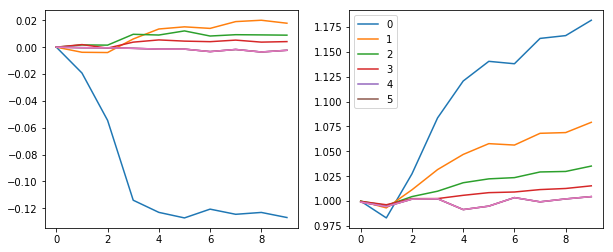

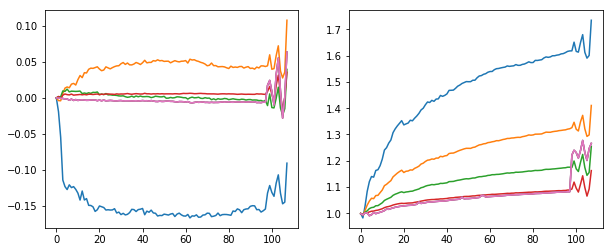

In [15]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [13]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [14]:
%time run.fit(3, learn)

train: [0.25310638671875, tensor(0.9195, device='cuda:0')]
valid: [0.1629533935546875, tensor(0.9513, device='cuda:0')]
train: [0.077422421875, tensor(0.9765, device='cuda:0')]
valid: [0.11033271484375, tensor(0.9655, device='cuda:0')]
train: [0.054823671875, tensor(0.9835, device='cuda:0')]
valid: [0.07338250732421875, tensor(0.9768, device='cuda:0')]
CPU times: user 12.5 s, sys: 2.98 s, total: 15.5 s
Wall time: 15.5 s


### Builtin batchnorm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

In [15]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [16]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [17]:
%time run.fit(3, learn)

train: [0.261401640625, tensor(0.9238, device='cuda:0')]
valid: [0.1479271240234375, tensor(0.9517, device='cuda:0')]
train: [0.072921455078125, tensor(0.9772, device='cuda:0')]
valid: [0.08903743896484374, tensor(0.9733, device='cuda:0')]
train: [0.052027099609375, tensor(0.9838, device='cuda:0')]
valid: [0.06108431396484375, tensor(0.9804, device='cuda:0')]
CPU times: user 11.3 s, sys: 2.37 s, total: 13.7 s
Wall time: 13.8 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [19]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [20]:
run.fit(8, learn)

train: [0.31647228515625, tensor(0.9062, device='cuda:0')]
valid: [0.141310986328125, tensor(0.9565, device='cuda:0')]
train: [0.09898029296875, tensor(0.9701, device='cuda:0')]
valid: [0.11971199951171875, tensor(0.9652, device='cuda:0')]
train: [0.06806630859375, tensor(0.9786, device='cuda:0')]
valid: [0.07510550537109376, tensor(0.9766, device='cuda:0')]
train: [0.0429486865234375, tensor(0.9863, device='cuda:0')]
valid: [0.0596386962890625, tensor(0.9814, device='cuda:0')]
train: [0.0292974560546875, tensor(0.9906, device='cuda:0')]
valid: [0.05085914001464844, tensor(0.9857, device='cuda:0')]
train: [0.01904771240234375, tensor(0.9945, device='cuda:0')]
valid: [0.044835992431640624, tensor(0.9863, device='cuda:0')]
train: [0.01245054443359375, tensor(0.9970, device='cuda:0')]
valid: [0.04183270263671875, tensor(0.9878, device='cuda:0')]
train: [0.008412266845703125, tensor(0.9986, device='cuda:0')]
valid: [0.042111663818359374, tensor(0.9877, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [21]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [22]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [23]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [24]:
%time run.fit(3, learn)

train: [nan, tensor(0.1210, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 15.4 s, sys: 3.99 s, total: 19.4 s
Wall time: 19.4 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [25]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [26]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [27]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [28]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 16.5 s, sys: 4.32 s, total: 20.8 s
Wall time: 20.8 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [29]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [30]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [31]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [32]:
%time run.fit(1, learn)

train: [2.32158203125, tensor(0.1925, device='cuda:0')]
valid: [1.951426171875, tensor(0.2837, device='cuda:0')]
CPU times: user 1min 30s, sys: 1.81 s, total: 1min 32s
Wall time: 1min 32s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [33]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [34]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [35]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [36]:
%time run.fit(1, learn)

train: [0.4153578125, tensor(0.8900, device='cuda:0')]
valid: [0.2260486572265625, tensor(0.9460, device='cuda:0')]
CPU times: user 5min 15s, sys: 26.9 s, total: 5min 42s
Wall time: 5min 44s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [37]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [38]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

Metrics:
<function accuracy at 0x7f27aa6f57b8>
Metrics:
<function accuracy at 0x7f27aa6f57b8>


In [39]:
%time run.fit(1, learn)

train: [0.162093759765625, tensor(0.9495, device='cuda:0')]
valid: [0.16422022705078124, tensor(0.9780, device='cuda:0')]
CPU times: user 15.7 s, sys: 612 ms, total: 16.3 s
Wall time: 16.3 s


## Export

In [40]:
nb_auto_export()

<IPython.core.display.Javascript object>